In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

from randomly_sampled_model import StorageBox

# Load data

In [2]:
data_path = 'hydrologic_data.csv'

df_hydrologic_data = pd.read_csv(data_path)

J = df_hydrologic_data['J [mm/h]'].to_numpy()
Q = df_hydrologic_data['Q [mm/h]'].to_numpy()
ET = df_hydrologic_data['ET [mm/h]'].to_numpy()
m_i = df_hydrologic_data['m_i [mass/h]'].to_numpy()

# Initialize and run the model

In [3]:
# Initialization
S0 = 365 * 24 * np.mean(J)  # in mm

DT50 = 1000
k_reaction = np.log(2) / DT50  # k_reaction = 0
R = 1.5
alpha = .8

M0 = np.mean(m_i) / ((np.mean(Q) + alpha * np.mean(ET)) / (R * S0) + k_reaction)

max_age_tracked = 10000  # in hours

storage = StorageBox(
    initial_storage=S0, initial_mass=M0, reaction_rate=k_reaction,
    retardation_factor=R, evapoconcentration_factor=alpha,
    run_NBTC_Q=True, run_NBTC_ET=False, run_NBTC_react=False,
    run_tracer_bTTD=True, run_water_bTTD=True, max_age_tracked=max_age_tracked
    )

storage.set_input([J, m_i], [Q, ET])

In [4]:
# Run (can take several minutes depending on maximum age tracked and data length)
storage.run()

# Visualize results

### Input data

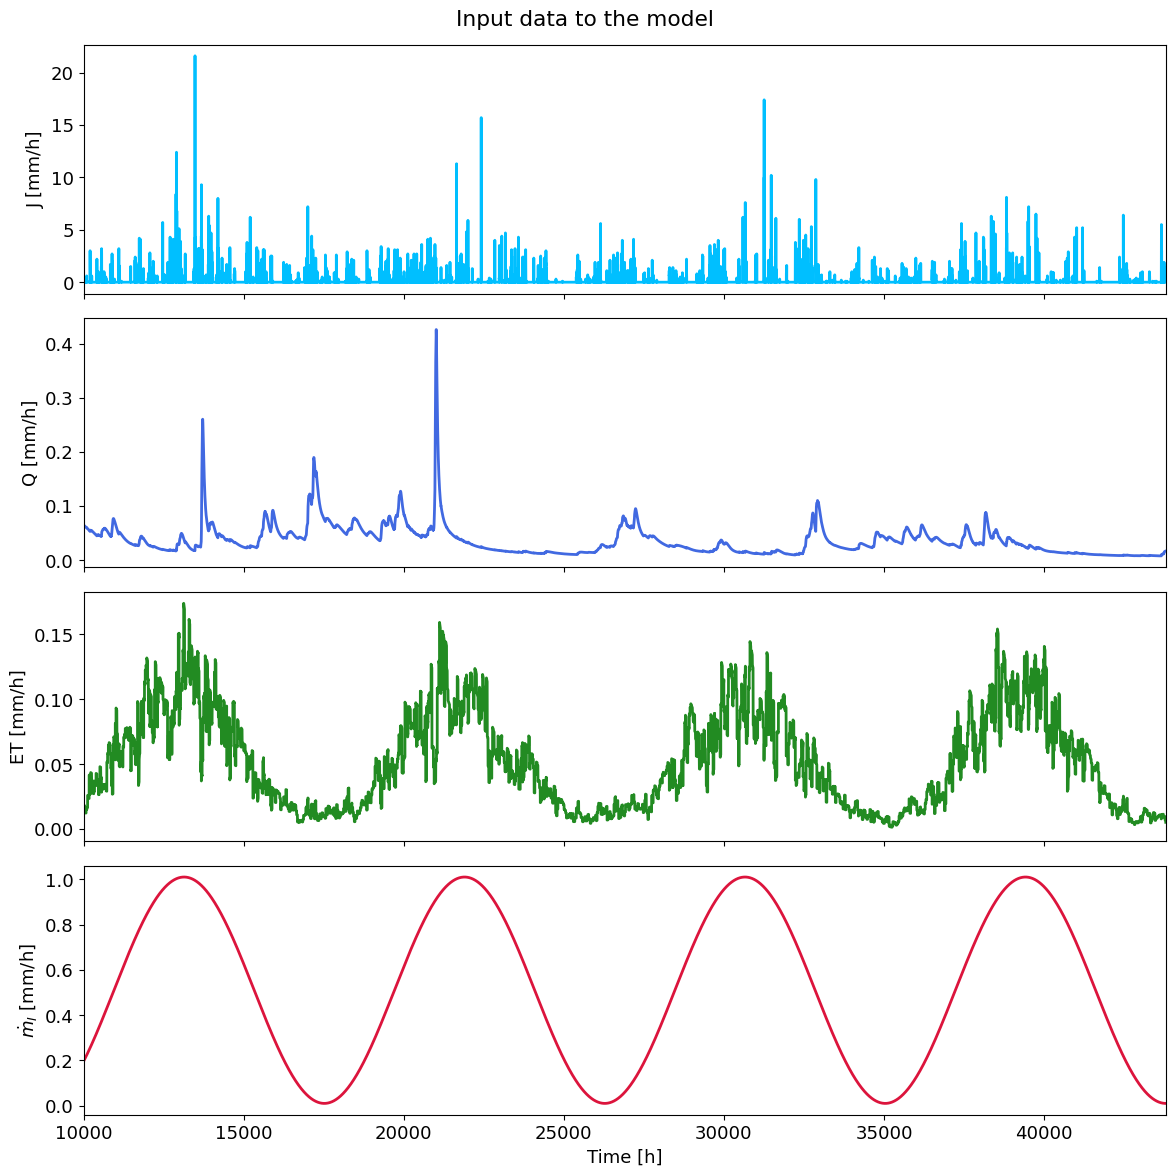

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axs[0].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.input_water_flux, c='deepskyblue', lw=2)
axs[1].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.output_Q, c='royalblue', lw=2)
axs[2].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.output_ET, c='forestgreen', lw=2)
axs[3].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.input_mass_flux, c='crimson', lw=2)

axs[0].set_ylabel('J [mm/h]')
axs[1].set_ylabel('Q [mm/h]')
axs[2].set_ylabel('ET [mm/h]')
axs[3].set_ylabel(r'$\dot{m}_I$ [mm/h]')

axs[3].set_xlabel('Time [h]')

axs[3].set_xlim(xmin=10000, xmax=df_hydrologic_data['Time [h]'].to_numpy()[43800])

fig.suptitle('Input data to the model')

fig.tight_layout()

### Output data

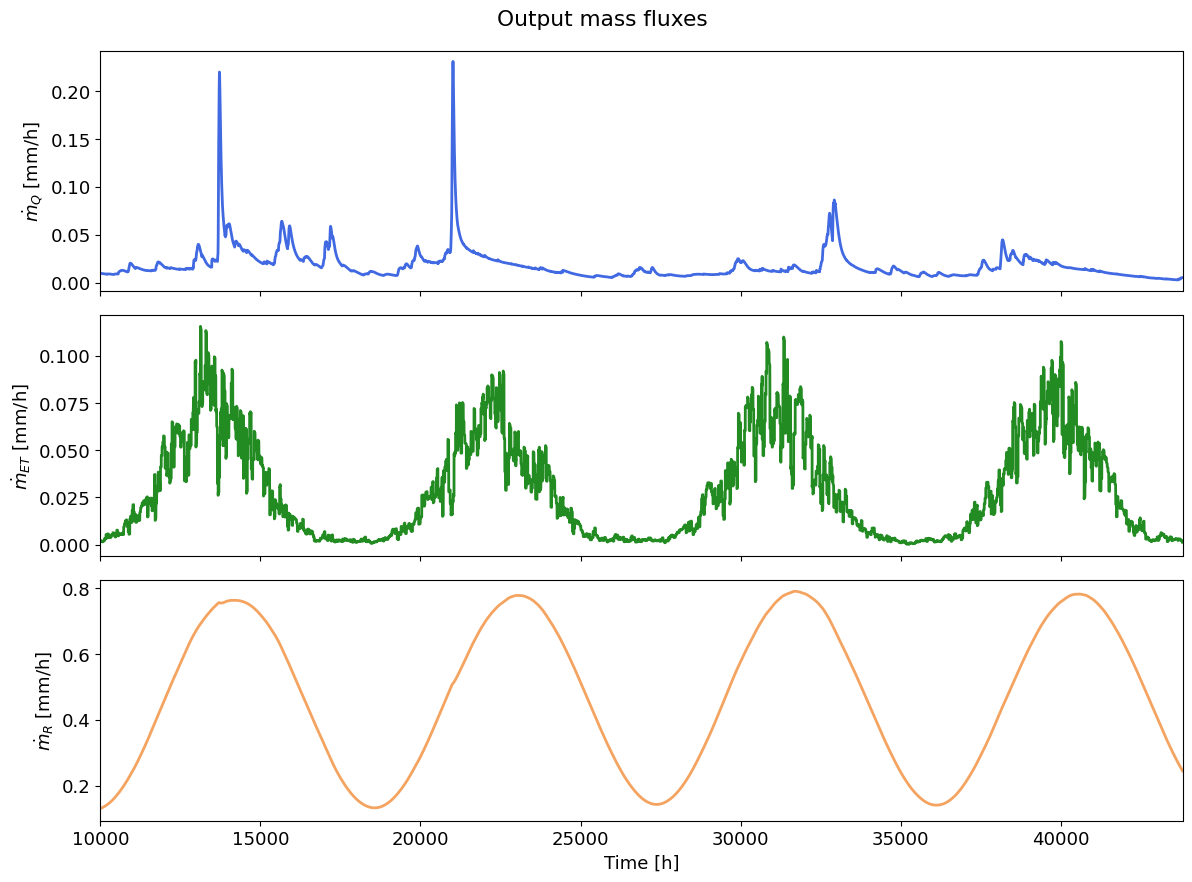

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axs[0].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.output_Q_mass, c='royalblue', lw=2)
axs[1].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.output_ET_mass, c='forestgreen', lw=2)
axs[2].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.output_reacted_mass, c='sandybrown', lw=2)

axs[0].set_ylabel(r'$\dot{m}_Q$ [mm/h]')
axs[1].set_ylabel(r'$\dot{m}_{ET}$ [mm/h]')
axs[2].set_ylabel(r'$\dot{m}_R$ [mm/h]')

axs[2].set_xlabel('Time [h]')

axs[2].set_xlim(xmin=10000, xmax=df_hydrologic_data['Time [h]'].to_numpy()[43800])

fig.suptitle('Output mass fluxes')

fig.tight_layout()

### State variables

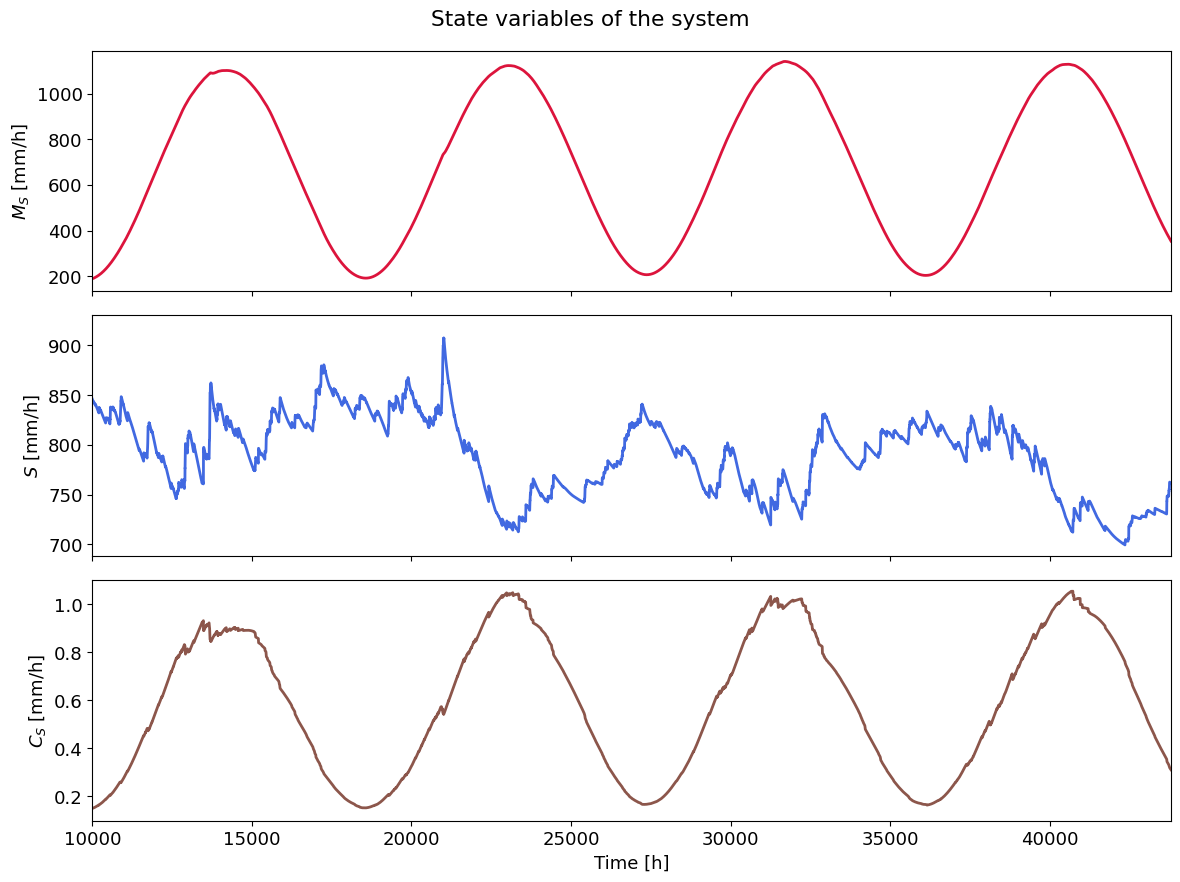

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axs[0].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.storage_mass[:-1], c='crimson', lw=2)
axs[1].plot(df_hydrologic_data['Time [h]'].to_numpy(), storage.storage[:-1], c='royalblue', lw=2)
axs[2].plot(df_hydrologic_data['Time [h]'].to_numpy(), 1 / R * storage.storage_mass[:-1] /storage.storage[:-1],
            c='tab:brown', lw=2)

axs[0].set_ylabel(r'$M_S$ [mm/h]')
axs[1].set_ylabel(r'$S$ [mm/h]')
axs[2].set_ylabel(r'$C_S$ [mm/h]')

axs[2].set_xlabel('Time [h]')

axs[2].set_xlim(xmin=10000, xmax=df_hydrologic_data['Time [h]'].to_numpy()[43800])

fig.suptitle('State variables of the system')

fig.tight_layout()

### Water and tracer age distributions

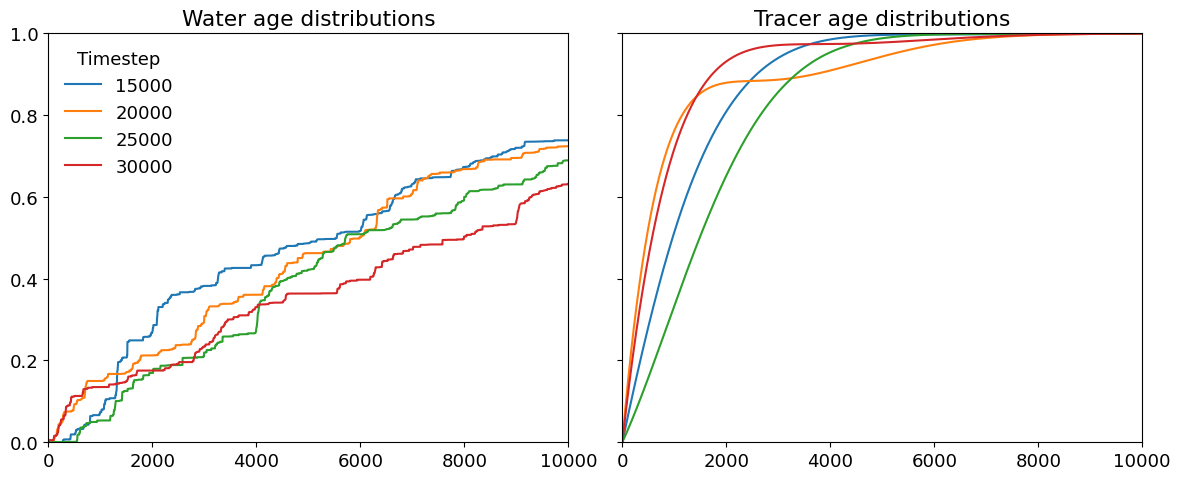

In [8]:
timesteps_of_interest = [15000, 20000, 25000, 30000]

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for t in timesteps_of_interest:
    axs[0].plot(np.cumsum(storage.water_bTTD[t, :]), label=t)
    axs[1].plot(np.cumsum(storage.tracer_bTTD[t, :]), label=t)

axs[0].legend(title='Timestep', frameon=False)

axs[0].set_title('Water age distributions')
axs[1].set_title('Tracer age distributions')

axs[0].set_xlim(xmin=0, xmax=max_age_tracked)
axs[1].set_xlim(xmin=0, xmax=max_age_tracked)

axs[0].set_ylim(ymin=0, ymax=1)

fig.tight_layout()

### Normalized breakthrough curves in streamflow

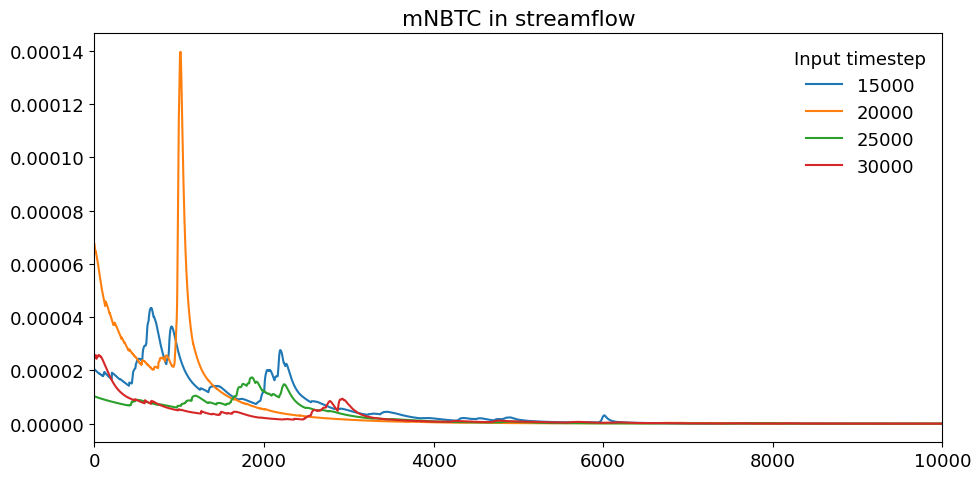

In [9]:
timesteps_of_interest = [15000, 20000, 25000, 30000]

fig, ax = plt.subplots(figsize=(10, 5))

for t in timesteps_of_interest:
    ax.plot(storage.NBTC_Q[t], label=t)

ax.legend(title='Input timestep', frameon=False)

ax.set_xlim(xmin=0, xmax=max_age_tracked)
ax.set_title('mNBTC in streamflow')

fig.tight_layout()